## Analysis of Portenga and Bierman (2011) supplementary data

In [6]:
import pandas as pd
import os
import numpy as np
folder ='/Users/gr_1/Documents/cosmo_predict/'
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

ModuleNotFoundError: No module named 'seaborn'

## step 1 Load excel sheet, look at basin averaged rates (sheets 4 - 12), concatenate

In [225]:

a = pd.DataFrame()
for i in range(4,12):
    b = pd.read_excel(folder + 'rates_cosmo.xlsx',sheet_name = i)
    if i < 4:
        b['type'] = 'bedrock'
    else:
        b['type'] = 'basinwide'
    a = a.append(b)
a.index = range(0,len(a))

<ipython-input-225-9c6d9665ea42>:3: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  b = pd.read_excel(folder + 'rates_cosmo.xlsx',sheet_name = i)


## Some of the data labels are messed up, correct

In [226]:
for col in a.columns:
    for i in range(len(a)):
        if len(str(a[col][i:i+1].values[0]).split("\n"))>1:
            a.loc[i,col] = str(a[col][i:i+1].values[0]).split('\n')[0]
    if 'Unnamed' in str(col):
        a = a.drop(col,1)
for s in range(len(a)):
    a.loc[s,'Climate Zone (Sub-category)'] = str(a.loc[s,'Climate Zone (Sub-category)']).lower()

## Want to discretize continuous data for the seaborn box plots

In [227]:
a_discrete = pd.DataFrame()
for col in a.columns:
    try:
        cval = pd.to_numeric(a[col],errors='coerce')
        a_discrete[col+' binned'] = pd.cut(cval,bins = np.arange(min(cval),max(cval),(max(cval)-min(cval))/8))
    except:
        a_discrete[col] = a[col]
    
a_discrete['CRONUS Erosion Rate (m My)'] = pd.to_numeric(a['CRONUS Erosion Rate (m My)'],errors='coerce')



## Box plots of excel variables vs. Cronus erosion rates

In [228]:
if 0:
    c = 0
    for col in np.flip(a_discrete.columns[3:-5]):

        fig_ax = plt.subplots(figsize=(10,5))
        g = sns.boxplot(data = a_discrete,y='CRONUS Erosion Rate (m My)',x=col)
        plt.xticks(rotation=80)
        g.set_yscale('log')
        c += 1

## Random forest regression

In [229]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVR
from sklearn import impute
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [230]:
a['dist'] = np.sqrt(np.float64(a['Longitude (decimal degrees)'])**2 + np.float64(a['Latitude (decimal degrees)'])**2)
a['Longitude (decimal degrees)'] = np.float64(a['Longitude (decimal degrees)'])

In [231]:
a['dist_bin'] = pd.factorize(pd.cut(pd.to_numeric(a['Longitude (decimal degrees)']),50))[0]

In [232]:
a2 = pd.DataFrame()
for i,data in a.groupby('dist_bin'):  
    if len(data) > 0:
        a3 = data.mean()
        for col in a.columns:
            if (a[col].dtype != np.number):
                a3[col] = data.iloc[0][col]
        a2 = a2.append(a3,ignore_index=True)

#a = a2

<ipython-input-232-91ece3074b6c>:6: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (a[col].dtype != np.number):


In [233]:
a = a.sort_values('Longitude (decimal degrees)')
#a=a[::-1]

## Data prep

In [234]:
#a = a[::-1]
a_rf = pd.DataFrame()
for col in a.columns[4:-3]:
    try:

        if ('Latitude' in col) | ('Longitude' in col):
            continue
        cval = pd.to_numeric(a[col],errors='coerce')
       # print(max(cval))

        pd.cut(cval,bins = np.arange(min(cval),max(cval),(max(cval)-min(cval))/8))

        a_rf[col] = cval
    except Exception as e:
        print(e)
        le = sklearn.preprocessing.LabelEncoder()
        le.fit(a[col].astype('str').values)
        l = le.transform(a[col].astype('str').values) 
        a_rf[col] = l

    
a_rf['CRONUS Erosion Rate (m My)'] = pd.to_numeric(a['CRONUS Erosion Rate (m My)'],errors='coerce')

a_rf = a_rf.drop(np.where(a['Mean Basin Elevation (m)'].isna())[0])

arange: cannot compute length
arange: cannot compute length
arange: cannot compute length
arange: cannot compute length
arange: cannot compute length


In [235]:
if 0:
    a_rf.index = range(len(a_rf))
    lencvs = int(np.floor(len(a_rf)/ncv))
    test_ids = []
    a_rf2 = pd.DataFrame()
    for i in range(ncv):
        if i < ncv-1:
            a_rf_sub = a_rf.iloc[i * lencvs : (i+1) *lencvs]
        else:
            a_rf_sub = a_rf.iloc[i * lencvs ::]
        #test_ids.append(a_rf_sub.sample(frac=1).index)
        a_rf2 = a_rf2.append(a_rf_sub.sample(frac=1))
    a_rf = a_rf2

# Cross validation - test dataset vs estimate with random forests

Cross-validation # 0
r2 =  0.46021013686177137
Cross-validation # 1
r2 =  -0.642911145265916
Cross-validation # 2
r2 =  0.47507990476346873


<ipython-input-236-23050450f5b9>:83: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0 ,1000])
<ipython-input-236-23050450f5b9>:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0 ,1000])
<ipython-input-236-23050450f5b9>:83: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0 ,1000])
<ipython-input-236-23050450f5b9>:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0 ,1000])
<ipython-input-236-23050450f5b9>:83: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0 ,1000])
<ipython-input-236-23050450f5b9>:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0 ,1000])


Cross-validation # 3
r2 =  0.5323842194375435
Cross-validation # 4
r2 =  -0.37311020131615913
0.09033058289614171
0.7088997295148267


<ipython-input-236-23050450f5b9>:83: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0 ,1000])
<ipython-input-236-23050450f5b9>:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0 ,1000])
<ipython-input-236-23050450f5b9>:83: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0 ,1000])
<ipython-input-236-23050450f5b9>:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0 ,1000])


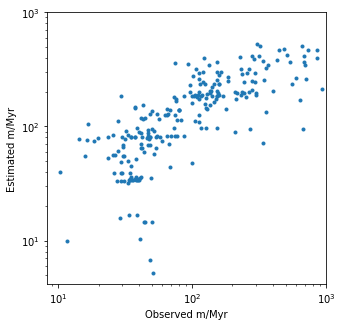

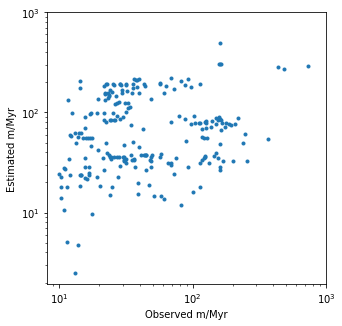

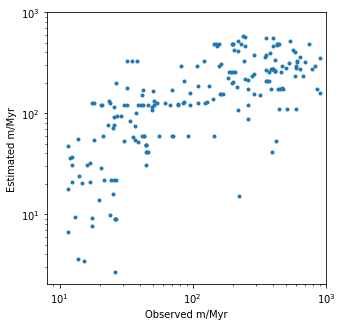

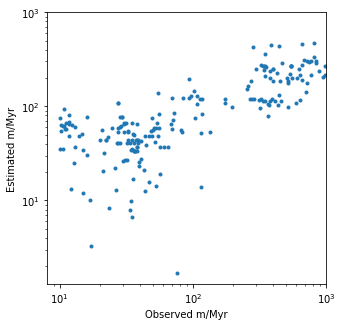

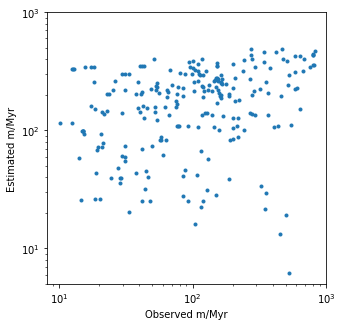

In [236]:
#a_rf = a_rf.sample(frac=1)
a_rf.index = range(len(a_rf))
selected_vars = ['Mean Basin Elevation (m)','Basin Relief (m)',
                'Climate Zone (Main)','Mean Basin Slope (°)','Mean Annual Precipitation (mm yr)',
                'Mean Annual Temperature (°C)','Seismicity','Seismic Regime']
#selected_vars = ['Mean Basin Slope (°)']
try:
    a_rf = a_rf.drop('CRONUS Erosion Rate Error (m My)',1)
except:
    print('here')
predictors = a_rf.drop('CRONUS Erosion Rate (m My)',1)

targets = a_rf['CRONUS Erosion Rate (m My)']
predictors.index = range(len(predictors))
targets.index = range(len(predictors))
a_rf.index = range(len(a_rf))
select = False
ero_thres = True
if select:
    predictors = predictors[selected_vars]
if ero_thres:
    
        drop_rows = np.where((targets>1000)|(targets<10))[0]
        for drop_row in drop_rows:
            predictors = predictors.drop(drop_row)
            targets = targets.drop(drop_row)

model = SVR(C=1000)#max_depth=50,criterion='mse',bootstrap = 'True',min_samples_split=50)
#model = RandomForestRegressor()
seed = 5
cv = model_selection.KFold(n_splits=ncv)
a_rf.index = range(len(a_rf))
c=0
mnr2=0
mnmn =0
for train_index, test_index in cv.split(predictors):
    X_train, X_test = predictors.iloc[train_index].values, predictors.iloc[test_index].values
    X_train[X_train>5000000] = np.nan
    y_train, y_test = targets.iloc[train_index].values, targets.iloc[test_index].values
    y_train,y_test = y_train.reshape(-1,1),y_test.reshape(-1,1)
    #y_train[y_train>500] = 500

    imp = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(X_train)
    X_train = imp.transform(X_train)
    imp = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(X_test)
    X_test = imp.transform(X_test)
    imp = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(y_train)
    y_train = imp.transform(y_train).ravel()
    imp = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(y_test)
    y_test = imp.transform(y_test).ravel()
    # For training, fit() is used
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
    X_train = scaling.transform(X_train)
    X_test = scaling.transform(X_test)
    model.fit(X_train, y_train)

    # Default metric is R2 for regression, which can be accessed by score()
    model.score(X_test, y_test)

    # For other metrics, we need the predictions of the model
    y_pred = model.predict(X_test)
    fig,ax = plt.subplots(figsize=(5,5))
    plt.plot(y_test,y_pred,'.')
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.xlabel('Observed m/Myr')
    plt.ylabel('Estimated m/Myr')
    print('Cross-validation # ' + str(c))
    #print('Median error = ', metrics.median_absolute_error(y_test, y_pred))

    y_test_n = y_test[np.logical_and(y_test>0,y_pred>0)]
    y_pred_n = y_pred[np.logical_and(y_pred>0,y_test>0)]
    r2 = metrics.r2_score(np.log(y_test_n),np.log(y_pred_n))
    mn = metrics.median_absolute_error(np.log(y_test_n), np.log(y_pred_n))
    print('r2 = ',r2)
    mnmn+=mn
    mnr2+=r2
    c+=1
    plt.xlim([0 ,1000])
    plt.ylim([0 ,1000])
print(mnr2/c)
print(mnmn/c)

## Baseline

In [187]:
a_rf

,Mean Basin Elevation (m),Basin Relief (m),Basin Area (km ),Effective Basin Elevation (m),Mean Basin Slope (°),Rock Type (General),Mean Annual Precipitation (mm yr),Mean Annual Temperature (°C),% Vegetation,Seismicity,Seismic Regime,Climate Zone (Main),Climate Zone (Sub-category),CRONUS Erosion Rate (m My),
0,1114.0,2541.0,29337.70,1155.0,3.0,2,300.0,20.0,8.0,0.310600,0,0,7,6.79,0
1,1061.0,286.0,174.08,1063.0,1.5,2,222.0,20.0,1.0,0.310600,0,0,6,8.46,0
2,1305.0,1483.0,7374.15,1320.0,3.0,2,314.0,19.0,5.0,0.310600,0,0,6,9.92,0
3,1280.0,1598.0,7971.20,1297.0,2.9,2,303.0,19.0,5.0,0.310600,0,0,6,9.77,0
4,1147.0,2286.0,11490.00,1177.0,2.7,2,240.0,20.0,3.0,0.310600,0,0,6,1.51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,919.0,864.0,23.17,929.0,9.0,0,801.0,10.0,80.0,0.876407,0,3,16,92.44,0
1385,919.0,858.0,23.15,931.0,9.0,0,801.0,10.0,80.0,0.876407,0,3,16,119.44,0
1386,919.0,858.0,23.15,931.0,9.0,0,801.0,10.0,80.0,0.876407,0,3,16,42.07,0
1387,1005.0,251.0,5.98,1007.0,6.7,0,801.0,9.0,80.0,0.876407,0,3,16,28.46,0


-0.23291772831576535
83.50607128068205


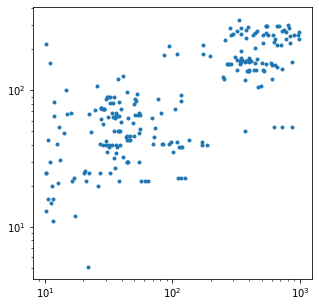

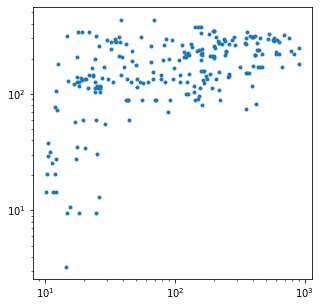

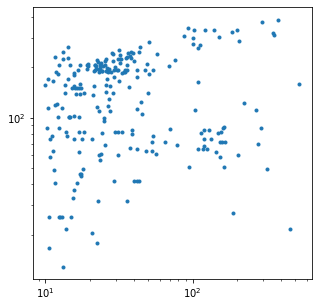

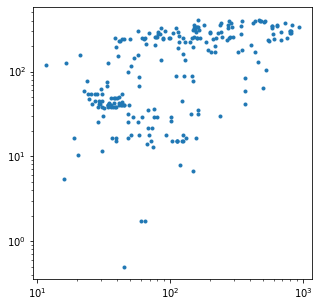

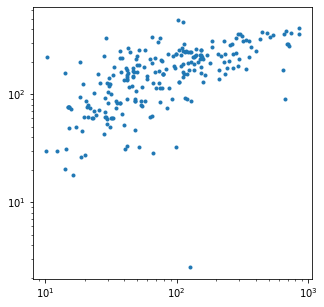

In [190]:
from sklearn.linear_model import LinearRegression
c=0
mnr2=0
mnmn = 0
cv = model_selection.KFold(n_splits=ncv)

for train_index, test_index in cv.split(predictors):
    mod = LinearRegression()
    X_train, X_test = predictors.iloc[train_index].values, predictors.iloc[test_index].values
    y_train, y_test = targets.iloc[train_index].values, targets.iloc[test_index].values
    
    X_train = X_train[:,4]
    X_test = X_test[:,4]
    isn = np.where(np.logical_not(np.isnan(X_train)))
    isn2 = np.where(np.logical_not((np.isnan(X_test))))
    mod = mod.fit(X_train[isn].reshape(-1,1),y_train[isn].reshape(-1,1))
    
    p = mod.predict((X_test[isn2].reshape(-1,1)))
    #e = np.mean((p - np.log(y_train[isn2]))**2)
    #p = np.exp(p) * 1#np.exp(e/2)
    fig,ax = plt.subplots(figsize=(5,5))
    #plt.plot(x,p,markersize=10)
    #plt.plot(a_rf[a_rf.columns[i]], np.float64(a_rf['CRONUS Erosion Rate (m My)']),'.')
    plt.plot(y_test[isn2],p,'.')
    r2 = metrics.r2_score(y_test[isn2],p)
    mn = metrics.median_absolute_error(y_test[isn2], p)

    mnr2 += r2
    mnmn += mn
    ax.set_yscale('log')
    ax.set_xscale('log')
    c+=1
print(mnr2/c)
print(mnmn/c)


    #ax.set_ylim([.])


In [76]:
from sklearn.linear_model import LinearRegression
mod = LinearRegression()
x=np.abs(X_train[:,4].reshape(-1,1))
mod = mod.fit(x,np.log(np.abs(y_train)))
p = mod.predict(x)
e = np.mean((p - np.log(y_train))**2)
p = np.exp(p) * np.exp(e/2)
fig,ax = plt.subplots(figsize=(5,5))
#plt.plot(x,p,markersize=10)
#plt.plot(a_rf[a_rf.columns[i]], np.float64(a_rf['CRONUS Erosion Rate (m My)']),'.')
plt.plot(np.log(y_train),np.log(p),'.')
print(metrics.r2_score(np.log(np.abs(p)),np.log(np.abs(y_train))))

ax.set_yscale('log')
#ax.set_ylim([.])
ax.set_xlabel(a_rf.columns[i])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [160]:
np.mean(y_train)

154.14595663265305

In [224]:
a.to_csv('a.csv')